In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import cross_val_score,train_test_split,KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.ensemble import GradientBoostingClassifier as gbc
from sklearn.multiclass import OutputCodeClassifier
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier as knc
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [90]:
#정확도 누적 및 그래프 출력 함수

my_predictions = {}

colors = ['r', 'c', 'm', 'y', 'k', 'khaki', 'teal', 'orchid', 'sandybrown',
          'greenyellow', 'dodgerblue', 'deepskyblue', 'rosybrown', 'firebrick',
          'deeppink', 'crimson', 'salmon', 'darkred', 'olivedrab', 'olive',
          'forestgreen', 'royalblue', 'indigo', 'navy', 'mediumpurple', 'chocolate',
          'gold', 'darkorange', 'seagreen', 'turquoise', 'steelblue', 'slategray',
          'peru', 'midnightblue', 'slateblue', 'dimgray', 'cadetblue', 'tomato'
         ]

def accuracy_eval(name_, pred, actual):
    global predictions
    global colors

    plt.figure(figsize=(12, 9))

    acc = accuracy_score(actual, pred)
    my_predictions[name_] = acc * 100

    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=True)

    df = pd.DataFrame(y_value, columns=['model', 'accuracy'])
    print(df)

    length = len(df)

    plt.figure(figsize=(10, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=15)
    bars = ax.barh(np.arange(len(df)), df['accuracy'])

    for i, v in enumerate(df['accuracy']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v + 2, i, str(round(v, 3)), color='k', fontsize=15, fontweight='bold')

    plt.title('accuracy', fontsize=18)
    plt.xlim(0, 100)

    plt.show()

## Data loading

In [105]:
# Data loading

columns = ['AmVP_1', 'AmVP_2', 'AmVP_3', 'AmVP_4', 'AmVP_5',
           'AmPD_1', 'AmPD_2', 'AmPD_3', 'AmPD_4', 'AmPD_5',
           'AmVD_1', 'AmVD_2', 'AmVD_3', 'AmVD_4', 'AmVD_5',
           'RtVD_VP_1', 'RtVD_VP_2', 'RtVD_VP_3', 'RtVD_VP_4', 'RtVD_VP_5',
           'RtVD_PD_1', 'RtVD_PD_2', 'RtVD_PD_3', 'RtVD_PD_4', 'RtVD_PD_5',
           'TmPP_1', 'TmPP_2', 'TmPP_3', 'TmPP_4',
           'TmVD_1', 'TmVD_2', 'TmVD_3', 'TmVD_4', 'TmVD_5',
           'TmDV_1', 'TmDV_2', 'TmDV_3', 'TmDV_4', 'TmDV_5',
           'RSD_1', 'RSD_2', 'RSD_3', 'RSD_4', 'RSD_5',
           'RtArea_1', 'RtArea_2', 'RtArea_3', 'RtArea_4', 'RtArea_5'
          ]

folder_path = input()
is_binary = int(input("Type 2 or 3: "))
file_list = os.listdir(folder_path)
data = np.empty((0,49), dtype = float)
label = np.empty((0,), dtype = int)

for filename in file_list:
    if filename.endswith('.npz'):
        file_path = os.path.join(folder_path, filename)
        temp = np.load(file_path)
        data = np.insert(data, data.shape[0], temp['x'], axis = 0)
        if is_binary == 2:
            for i in range(len(temp['y_1'])):
                if temp['y_1'][i] > 1:
                    label = np.append(label, 2)
                else:
                    label = np.append(label, 1)
        if is_binary == 3:
            label = np.append(label, temp['y_1'])

print('로딩된 데이터:',data.shape)

 /media/yoonchul/T7/Lab/Research/PPG_drunk_detection/Dataset/npz_files/Attempt_2
Type 2 or 3:  2


로딩된 데이터: (9010, 49)


/media/yoonchul/T7/Lab/Research/PPG_drunk_detection/Dataset/npz_files/Attempt_2

In [107]:
# 머신러닝 알고리즘
x_train,x_test,y_train,y_test = train_test_split(data, label, test_size = 0.2, random_state = 10)

Decision Tree Classifier

In [ ]:
# Decision Tree Classifier

# GridSearchCV의 인자들:
# estimator - 알고리즘
# param_grid - 사용될 파라미터를 딕셔너리 형태로 삽입
# scoring - 예측 성능 픅정할 평가방법: 분류 - accuracy, f1 // 회귀: neg_mean_squared_error, r2
# cv - 교차검증에서 몇 개로 분할되는지 지정. 정수: K겹 교차검증
# refit: True로 하면 최적의 하이퍼파라미터를 찾아 estimator를 재학습시킴

pipe = [
    ('scaler', StandardScaler()),
    ('DTC', dtc())
]
pipe_dtc = Pipeline(pipe, verbose=False)

DTC = dtc()
param_dist = {
    'DTC__criterion':['gini','entropy'], 
    'DTC__max_depth':[None], 
    'DTC__max_leaf_nodes':[None], 
    'DTC__min_samples_split':[1,2,3], 
    'DTC__min_samples_leaf':[4], 
    'DTC__max_features':[None,'sqrt','log2',3,4,5]
    }

rand_dtc_search = GridSearchCV(pipe_dtc, param_grid = param_dist, cv = 5, scoring = 'accuracy', refit=True)
rand_dtc_search.fit(x_train, y_train)
                                     
print('best parameters : ', rand_dtc_search.best_params_)
print('best score : ', round(rand_dtc_search.best_score_, 4))
                                     
estimator_dtc = rand_dtc_search.best_estimator_

kf = KFold(n_splits = 5, shuffle = True, random_state = 50)
accuracy_history = []

for train_index, test_index in kf.split(data):

    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = label[train_index], label[test_index]

    res = estimator_dtc.fit(x_train, y_train)

    y_pred = res.predict(x_test) # 예측 라벨
    accuracy_history.append(accuracy_score(y_pred, y_test)) # 정확도 측정 및 기록

print("각 분할의 정확도 기록 :", accuracy_history)
print("평균 정확도 :", np.mean(accuracy_history))

Random Forest Classifier

                    model   accuracy
0  RandomForestClassifier  87.846837


<Figure size 1200x900 with 0 Axes>

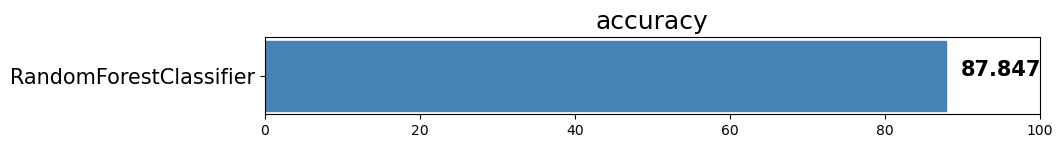

In [31]:
RFC =rfc(n_estimators=217,max_depth=None, min_samples_split=4,random_state=42)
RFC.fit(x_train,y_train)
y_pred = RFC.predict(x_test)
accuracy_eval('RandomForestClassifier', y_pred, y_test)

In [114]:
# RandomForest
pipe = [
    ('scaler', StandardScaler()),
    ('RFC', rfc())
]
pipe_rfc = Pipeline(pipe, verbose=False)

param_dist = {
    'RFC__n_estimators' : [217],
    'RFC__max_depth' : [None],
    'RFC__min_samples_leaf' : [8],
    'RFC__min_samples_split' : [8]
    }

rand_rfc_search = GridSearchCV(pipe_rfc, param_grid = param_dist, cv = 5, scoring = 'accuracy', refit=True)
rand_rfc_search.fit(x_train, y_train)
                                     
print('best parameters : ', rand_rfc_search.best_params_)
print('best score : ', round(rand_rfc_search.best_score_, 4))
                                     
estimator_rfc = rand_rfc_search.best_estimator_

kf = KFold(n_splits = 5, shuffle = True, random_state = 50)
accuracy_history = []

for train_index, test_index in kf.split(data):

    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = label[train_index], label[test_index]

    res = estimator_rfc.fit(x_train, y_train)

    y_pred = res.predict(x_test) # 예측 라벨
    accuracy_history.append(accuracy_score(y_pred, y_test)) # 정확도 측정 및 기록

print("각 분할의 정확도 기록 :", accuracy_history)
print("평균 정확도 :", np.mean(accuracy_history))

best parameters :  {'RFC__max_depth': None, 'RFC__min_samples_leaf': 8, 'RFC__min_samples_split': 8, 'RFC__n_estimators': 217}
best score :  0.815
각 분할의 정확도 기록 : [0.9389567147613762, 0.9378468368479467, 0.9322974472807991, 0.9400665926748057, 0.9328523862375139]
평균 정확도 : 0.9364039955604883


Gradient Boosting Classifier

                     model   accuracy
0   RandomForestClassifier  87.846837
1  GradientBoostClassifier  83.129856


<Figure size 1200x900 with 0 Axes>

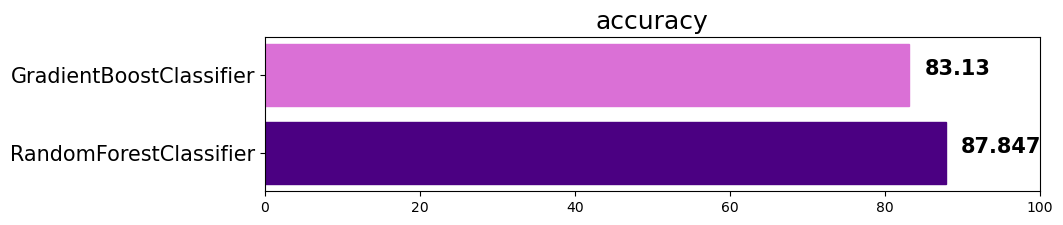

In [43]:
GBC = gbc()
GBC.fit(train_x,train_y)
pred_y = GBC.predict(test_x)
accuracy_eval('GradientBoostClassifier', pred_y,test_y)

In [115]:
# Gradient Boosting Classifier
# parameter 딕셔너리 설정할 때, 파이프 내 작업 이름 뒤 언더바 두 개 반드시 붙여야 함

pipe = [
    ('scaler', StandardScaler()),
    ('GBC', gbc())
]
pipeline_gbc = Pipeline(pipe, verbose=False)

cv=5

param_test = {
    "GBC__n_estimators":[250],
    "GBC__learning_rate": [0.1, 0.2, 0.3, 0.4, 0.5]
}
gs_gbc = GridSearchCV(pipeline_gbc, param_grid=param_test, cv=5, refit=True)
gs_gbc.fit(x_train, y_train)



estimator_gbc = gs_gbc.best_estimator_

print('final params', gs_gbc.best_params_)   # 최적의 파라미터 값 출력
print('best score', gs_gbc.best_score_)      # 최고의 점수

kf = KFold(n_splits = 5, shuffle = True, random_state = 50)
accuracy_history = []

for train_index, test_index in kf.split(data):

    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = label[train_index], label[test_index]

    res = estimator_gbc.fit(x_train, y_train)

    y_pred = res.predict(x_test) # 예측 라벨
    accuracy_history.append(accuracy_score(y_pred, y_test)) # 정확도 측정 및 기록

print("각 분할의 정확도 기록 :", accuracy_history)
print("평균 정확도 :", np.mean(accuracy_history))

final params {'GBC__learning_rate': 0.1, 'GBC__n_estimators': 250}
best score 0.85391280327173
각 분할의 정확도 기록 : [0.9361820199778025, 0.937291897891232, 0.9311875693673696, 0.9378468368479467, 0.9345172031076582]
평균 정확도 : 0.9354051054384017


SVM

In [117]:
# SVM 

pipe = [
    ('scaler', StandardScaler()),
    ('svm', SVC())
]
pipeline_svm = Pipeline(pipe, verbose=False)

cv=5

param_grid = {
    'svm__C':[10],
    'svm__gamma':[0.1]
}
gs_SVM = GridSearchCV(pipeline_svm, param_grid=param_grid, cv=5, refit=True)
gs_SVM.fit(x_train, y_train)



estimator_svm = gs_SVM.best_estimator_

print('final params', gs_SVM.best_params_)   # 최적의 파라미터 값 출력
print('best score', gs_SVM.best_score_)      # 최고의 점수

kf = KFold(n_splits = 5, shuffle = True, random_state = 50)
accuracy_history = []

for train_index, test_index in kf.split(data):

    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = label[train_index], label[test_index]

    res = estimator_svm.fit(x_train, y_train)

    y_pred = res.predict(x_test) # 예측 라벨
    accuracy_history.append(accuracy_score(y_pred, y_test)) # 정확도 측정 및 기록

print("각 분할의 정확도 기록 :", accuracy_history)
print("평균 정확도 :", np.mean(accuracy_history))

final params {'svm__C': 10, 'svm__gamma': 0.1}
best score 0.7744247377909276
각 분할의 정확도 기록 : [0.9544950055493896, 0.9522752497225305, 0.9483906770255272, 0.9567147613762487, 0.9517203107658158]
평균 정확도 : 0.9527192008879023


In [41]:
scores_df = pd.DataFrame(gs_SVM.cv_results_)
scores_df[['params', 'mean_test_score', 'rank_test_score', \
           'split0_test_score', 'split1_test_score', 'split2_test_score', 
           'split3_test_score', 'split4_test_score']]

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
0,"{'svm__C': 10, 'svm__gamma': 0.1}",0.881521,1,0.884189,0.869626,0.886269,0.880638,0.886884


# Result

binary_classification = {"Dicision Tree": 89.48,
                         "Random Forest": 93.64,
                         "Gradient boosting classifier" : 93.54,
                         "Support Vector Machine" : 95.27,
                         "LSTM" : }
                         
                         
trit_classification = {"Gradient boosting classifier": 87.17,
                       "Support Vector Machine" : 88.59
                      }